In [1]:
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
import sys

import sys
import io

In [2]:
# ---------- Fonctions ----------
def meilleur_profit(debut, fin, ligne, parent=None):
    """
    Renvoie le meilleur profit entre la colonne 'debut' et 'fin' (inclus),
    à la ligne 'ligne'.

    Deux options :
    1) Découper le sous-problème en sous-parties.
    2) Prendre la somme de tous les minerais entre [debut; fin] moins le pallier.
    """
    global profit_dyn, id_counter, appel_recursif

    current_id = id_counter
    id_counter += 1

    appel_recursif.append(
        (current_id, parent, debut, fin, ligne))  # Enregistrer l'appel

    if profit_dyn[debut][fin][ligne] == INCONNU:  # Diviser pour régner
        profit_max = 0

        # ----- 1) Découpage -----
        for i in range(debut, fin):
            profit = meilleur_profit(debut, i, ligne, current_id) + meilleur_profit(
                i + 1, fin, ligne, current_id)
            profit_max = max(profit_max, profit)

        # ----- 2) On prend tout -----
        profit = 0
        for i in range(debut, fin + 1):
            profit += minerai[ligne][i]

        profit -= pallier  # On enlève le prix du pallier

        if ligne < nb_lignes - 1:  # On recommence pour la ligne suivante
            profit += meilleur_profit(debut, fin, ligne + 1, current_id)

        profit_max = max(profit_max, profit)

        # Mise à jour du tableau dynamique
        profit_dyn[debut][fin][ligne] = profit_max

    return profit_dyn[debut][fin][ligne]


# Fonction pour afficher le graphe des appels récursifs
def affiche_appels():
    print("ID | Parent | Debut | Fin | Ligne")
    for appel in appel_recursif:
        print(
            f"{appel[0]}  |   {appel[1]}   |   {appel[2]}   |   {appel[3]}   |   {appel[4]}")

    print("\nStructure d'arbre (ID -> Parent ID):")
    for appel in appel_recursif:
        if appel[1] is not None:
            print(f"{appel[0]} -> {appel[1]}")

In [3]:
import random
from typing import Final

import networkx as nx

color_options: Final[dict[str, str]] = {
    "node_color": "#ffffff",
    "edgecolors": "#111827",
    "edge_color": "#94a3b8",
}


def hierarchy_pos(
    G,
    root=None,
    width=1.0,
    vert_gap=0.2,
    vert_loc=0,
    leaf_vs_root_factor=0.5,
):
    """If the graph is a tree this will return the positions to plot this in a
    hierarchical layout.

    Based on Joel's answer at https://stackoverflow.com/a/29597209/2966723,
    but with some modifications.

    We include this because it may be useful for plotting transmission trees,
    and there is currently no networkx equivalent (though it may be coming soon).

    There are two basic approaches we think of to allocate the horizontal
    location of a node.

    - Top down: we allocate horizontal space to a node.  Then its ``k``
      descendants split up that horizontal space equally.  This tends to result
      in overlapping nodes when some have many descendants.
    - Bottom up: we allocate horizontal space to each leaf node.  A node at a
      higher level gets the entire space allocated to its descendant leaves.
      Based on this, leaf nodes at higher levels get the same space as leaf
      nodes very deep in the tree.

    We use use both of these approaches simultaneously with ``leaf_vs_root_factor``
    determining how much of the horizontal space is based on the bottom up
    or top down approaches.  ``0`` gives pure bottom up, while 1 gives pure top
    down.


    :Arguments:

    **G** the graph (must be a tree)

    **root** the root node of the tree
    - if the tree is directed and this is not given, the root will be found and used
    - if the tree is directed and this is given, then the positions will be
      just for the descendants of this node.
    - if the tree is undirected and not given, then a random choice will be used.

    **width** horizontal space allocated for this branch - avoids overlap with other branches

    **vert_gap** gap between levels of hierarchy

    **vert_loc** vertical location of root

    **leaf_vs_root_factor**

    xcenter: horizontal location of root
    """
    if not nx.is_tree(G):
        error_msg = "cannot use hierarchy_pos on a graph that is not a tree"
        raise TypeError(error_msg)

    if root is None:
        if isinstance(G, nx.DiGraph):
            root = next(
                iter(nx.topological_sort(G)),
            )  # allows back compatibility with nx version 1.11
        else:
            root = random.choice(list(G.nodes))

    def _hierarchy_pos(
        G,
        root,
        leftmost,
        width,
        leafdx=0.2,
        vert_gap=0.2,
        vert_loc=0,
        xcenter=0.5,
        rootpos=None,
        leafpos=None,
        parent=None,
    ):
        """See hierarchy_pos docstring for most arguments

        pos: a dict saying where all nodes go if they have been assigned
        parent: parent of this branch. - only affects it if non-directed

        """
        if rootpos is None:
            rootpos = {root: (xcenter, vert_loc)}
        else:
            rootpos[root] = (xcenter, vert_loc)
        if leafpos is None:
            leafpos = {}
        children = list(G.neighbors(root))
        leaf_count = 0
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)
        if len(children) != 0:
            rootdx = width / len(children)
            nextx = xcenter - width / 2 - rootdx / 2
            for child in children:
                nextx += rootdx
                rootpos, leafpos, newleaves = _hierarchy_pos(
                    G,
                    child,
                    leftmost + leaf_count * leafdx,
                    width=rootdx,
                    leafdx=leafdx,
                    vert_gap=vert_gap,
                    vert_loc=vert_loc - vert_gap,
                    xcenter=nextx,
                    rootpos=rootpos,
                    leafpos=leafpos,
                    parent=root,
                )
                leaf_count += newleaves

            leftmostchild = min((x for x, y in [leafpos[child] for child in children]))
            rightmostchild = max((x for x, y in [leafpos[child] for child in children]))
            leafpos[root] = ((leftmostchild + rightmostchild) / 2, vert_loc)
        else:
            leaf_count = 1
            leafpos[root] = (leftmost, vert_loc)
        #        pos[root] = (leftmost + (leaf_count-1)*dx/2., vert_loc)
        #        print(leaf_count)
        return rootpos, leafpos, leaf_count

    xcenter = width / 2.0
    if isinstance(G, nx.DiGraph):
        leafcount = len(
            [node for node in nx.descendants(G, root) if G.out_degree(node) == 0],
        )
    elif isinstance(G, nx.Graph):
        leafcount = len(
            [
                node
                for node in nx.node_connected_component(G, root)
                if G.degree(node) == 1 and node != root
            ],
        )
    rootpos, leafpos, leaf_count = _hierarchy_pos(
        G,
        root,
        0,
        width,
        leafdx=width * 1.0 / leafcount,
        vert_gap=vert_gap,
        vert_loc=vert_loc,
        xcenter=xcenter,
    )
    pos = {}
    for node in rootpos:
        pos[node] = (
            leaf_vs_root_factor * leafpos[node][0]
            + (1 - leaf_vs_root_factor) * rootpos[node][0],
            leafpos[node][1],
        )
    #    pos = {node:(leaf_vs_root_factor*x1+(1-leaf_vs_root_factor)*x2, y1) for ((x1,y1), (x2,y2)) in (leafpos[node], rootpos[node]) for node in rootpos}
    xmax = max(x for x, y in pos.values())
    for node in pos:
        pos[node] = (pos[node][0] * width / xmax, pos[node][1])
    return pos

In [46]:
def creer_arbre_appels(liste_appels: list) -> tuple[list[list[int]], list[str]]:
    liste_adjacence: list[list[int]] = []
    labels = {}
    for node in liste_appels:
        node_id, parent, debut, fin, ligne = node
        labels[node_id] = f"{debut}|{fin}|{ligne}"

        if parent is None:
            liste_adjacence.append([])
        else:
            liste_adjacence.append([parent])

    return liste_adjacence, labels


def affiche_arbre_appels(liste_adjacence: list[list[int]], labels: list[str]) -> None:
    
    plt.figure(figsize=(10, 3))
    tree = nx.DiGraph()

    # Ajouter des arêtes au graphe à partir de la liste d'adjacence
    for i, adj in enumerate(liste_adjacence):
        for node in adj:
            tree.add_edge(node, i)


    pos = hierarchy_pos(tree)
    nx.draw_networkx(tree, pos=pos, node_size=1000, font_color="white", **color_options)
    #pos = nx.spring_layout(tree, seed=3113794652)
    # nx.draw_networkx_edges(tree, pos)
    # nx.draw_networkx_nodes(tree, pos)
    nx.draw_networkx_labels(tree, pos, labels, font_size=10)

    plt.tight_layout()
    plt.axis("off")
    plt.show()

195


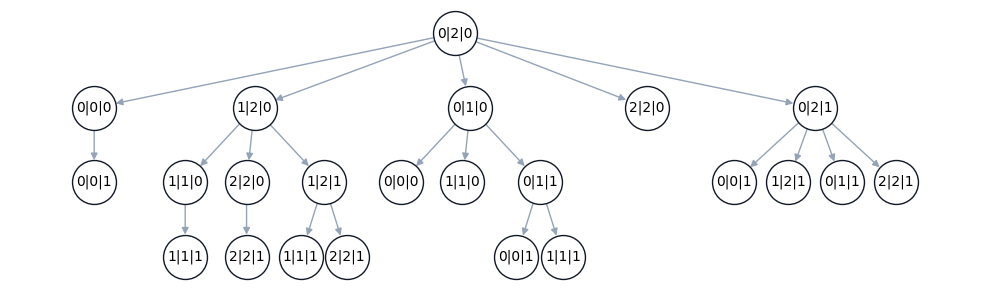

In [47]:

# ---------- Constantes ----------
L = 50
C = 50
INCONNU = 500 * 500 * 100 + 1

# ---------- Variables ----------
profit_dyn = [[[INCONNU for _ in range(L)] for _ in range(C)] for _ in range(C)]
minerai = [[0 for _ in range(C)] for _ in range(L)]

nb_lignes = 0
nb_colonnes = 0
pallier = 0

# Pour enregistrer les appels récursifs
appel_recursif = []
id_counter = 0





# ---------- Main ----------
if __name__ == "__main__":
    # -------- Lecture des entrées --------
    nb_lignes, nb_colonnes, pallier = 2, 3, 10
    

    minerai[0] = [100, 5, 100]
    minerai[1] = [-100, -100, -100]

    # -------- Initialisation --------
    for i in range(C):
        for j in range(i, C):
            for k in range(L):
                profit_dyn[i][j][k] = INCONNU

    for i in range(nb_colonnes):
        # Cas d'arrêt : profit_dyn[i][i][nb_lignes-1] = minerai[nb_lignes-1][i] -
        # pallier
        profit_dyn[i][i][nb_lignes - 1] = max(0, minerai[nb_lignes - 1][i] - pallier)

    # -------- Calcul du résultat --------
    resultat = meilleur_profit(0, nb_colonnes - 1, 0)

    # -------- Affichage du résultat --------
    print(resultat)

    # -------- Affichage des appels récursifs --------
    # affiche_appels()




a, b = creer_arbre_appels(appel_recursif)
affiche_arbre_appels(a, b)

